## Tensorflow 建模流程


尽管TensorFlow设计上足够灵活，可以用于进行各种复杂的数值计算。但通常人们使用TensorFlow来实现机器学习模型，尤其常用于实现神经网络模型。从原理上说可以使用张量构建计算图来定义神经网络，并通过自动微分机制训练模型。但为简洁起见，一般推荐使用TensorFlow的高层次keras接口来实现神经网络网模型。使用TensorFlow实现神经网络模型的一般流程包括：

- 准备数据
- 定义模型
- 训练模型
- 评估模型
- 使用模型
- 保存模型

**对新手来说，其中最困难的部分实际上是准备数据过程。**

我们在实践中通常会遇到的数据类型包括结构化数据，图片数据，文本数据，时间序列数据。

我们将分别以titanic生存预测问题，cifar2图片分类问题，imdb电影评论分类问题，国内新冠疫情结束时间预测问题为例，演示应用tensorflow对这四类数据的建模方法。

### 结构化数据建模

#### 准备数据


titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

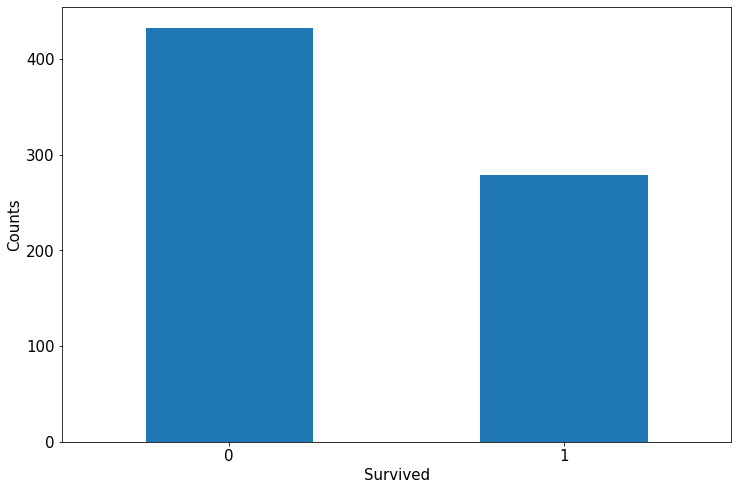

In [2]:
# label分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

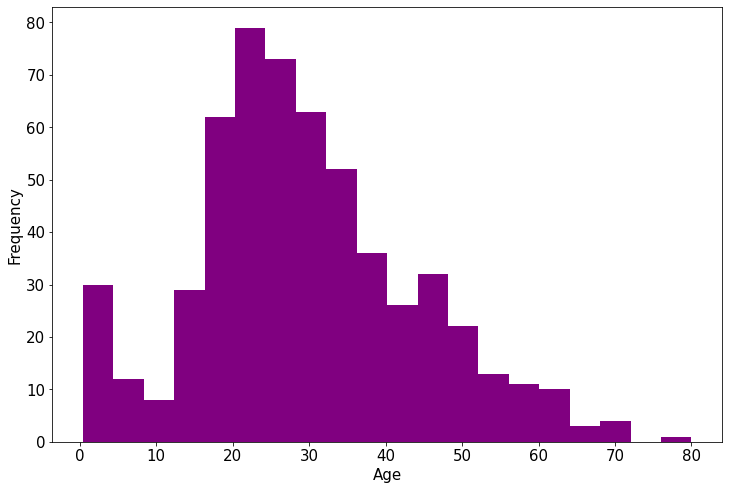

In [3]:
# 年龄分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

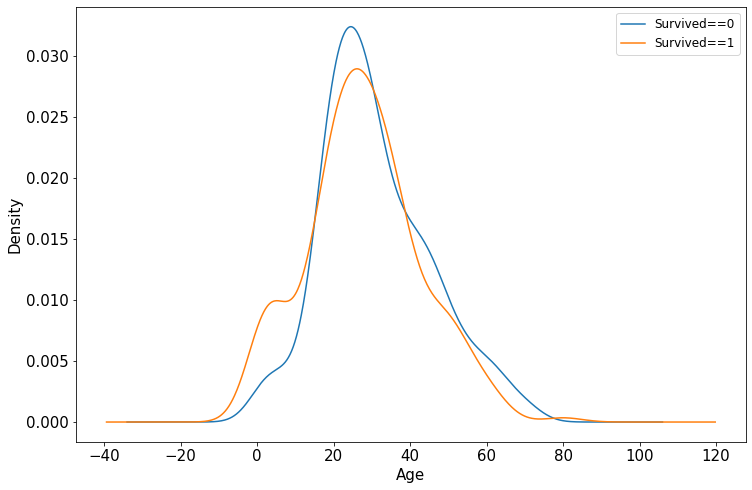

In [4]:
# 年龄和label的相关性
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [5]:
# 下面为正式的数据预处理
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

In [6]:
# 运行数据预处理
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


#### 定义模型

使用Keras接口有以下3种方式构建模型：

- 使用Sequential按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [7]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


#### 训练模型

训练模型通常有3种方法：

- 内置fit方法
- 内置train_on_batch方法
- 自定义训练循环。

此处我们选择最常用也最简单的内置fit方法。

In [8]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9/9 [==============================] - 0s 36ms/step - loss: 2.6084 - auc: 0.5488 - val_loss: 1.7385 - val_auc: 0.5785
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 1.4760 - auc: 0.5331 - val_loss: 1.0227 - val_auc: 0.5234
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 0.9215 - auc: 0.4749 - val_loss: 0.8054 - val_auc: 0.5150
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 0.7321 - auc: 0.5232 - val_loss: 0.6621 - val_auc: 0.6311
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6643 - auc: 0.6233 - val_loss: 0.6447 - val_auc: 0.6602
Epoch 6/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6630 - auc: 0.6526 - val_loss: 0.6448 - val_auc: 0.6617
Epoch 7/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6475 - auc: 0.6718 - val_loss: 0.6355 - val_auc: 0.6654
Epoch 8/30
9/9 [======

#### 评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


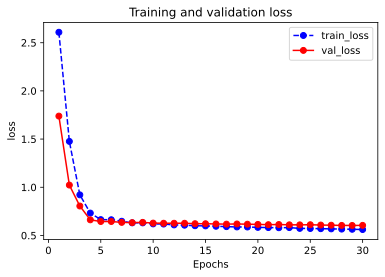

In [11]:
plot_metric(history,"loss")

In [12]:
# plot_metric(history,"AUC")

KeyError: 'AUC'

In [13]:
# 我们再看一下模型在测试集上的效果
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5665 - auc: 0.7485


[0.5664713382720947, 0.7484948039054871]

In [14]:
# 预测概率
model.predict(x_test[0:10])

array([[0.12093554],
       [0.42581785],
       [0.3822287 ],
       [0.7180943 ],
       [0.40336987],
       [0.37650588],
       [0.24047299],
       [0.5768708 ],
       [0.5536334 ],
       [0.24606408]], dtype=float32)

In [15]:
model.predict_classes(x_test[0:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

#### 保存模型

保存模型有两种方式，推荐TensorFlow原生方式进行保存。

- 使用Keras方式保存模型，仅仅适合使用Python环境恢复模型
- 使用TensorFlow原生方式保存，可以跨平台进行模型部署

In [18]:
# 保存模型结构及权重
model.save('./data/keras_model.h5')  

# 删除现有模型
del model

# identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5665 - auc: 0.7485


[0.5664713382720947, 0.7484948039054871]

In [19]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

# 保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5665 - auc: 0.7485


[0.5664713382720947, 0.7484948039054871]

In [20]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.
6/6 [==============================] - 0s 2ms/step - loss: 0.5665 - auc: 0.7485


[0.5664713382720947, 0.7484948039054871]

### 图片数据建模流程范例

#### 准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![img](./data/cifar2.jpg)

在tensorflow中准备图片数据的常用方案有两种：

- 使用 `tf.keras` 中的 `ImageDataGenerator` 工具构建图片数据生成器，这种更为简单，其使用范例可以参考以下文章：[Keras图像数据预处理范例——Cifar2图片分类](https://mp.weixin.qq.com/s?__biz=MzU3OTQzNTU2OA==&mid=2247484795&idx=1&sn=16947726702b87ee535aef0d6ae2db30&chksm=fd676824ca10e1321e77c5fa44339c0a79442cd8d7fbcc58697be166a4b0f990306848724692&mpshare=1&scene=1&srcid=1227ARPw2Ir8nVC4B84CjcIx&sharer_sharetime=1609043128020&sharer_shareid=808295d573831eb57288f1fc0ad3ac69&key=a58ea5adca8c8f06e4a7b7a15ed218f88cbee52ab3ee0fca3f2dd3f0797a36a6de26f8e75bd4787ddf97195c3959d94fe5060be0d3f9f6cd1eba11c0ad1ee37709088084d70034bd03efd43dacc32acd45a231c8359dd84ad73c28b11a9dc50556486b6e1e1ab89ad11da9621e5cdd858fcb53d91037d5116d638d12fced85b3&ascene=0&uin=MTYzMDEzMjAxMg%3D%3D&devicetype=iMac+MacBookAir7%2C2+OSX+OSX+10.14.6+build(18G6032)&version=11020113&lang=zh_CN&exportkey=A8nc9Ve3hcMzsggW3DOY8mU%3D&pass_ticket=JOjUjT6HXslkPfqXrPY1oG3qVEXbIIc1IAKdh8xjlrGyB8OtZ8JjRan45%2Ff%2Bknjb&wx_header=0)
- 使用 `tf.data.Dataset` 搭配 `tf.image` 中的一些图片处理方法构建数据管道，这种方法是TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。

In [22]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) # 注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)


In [23]:
# 使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

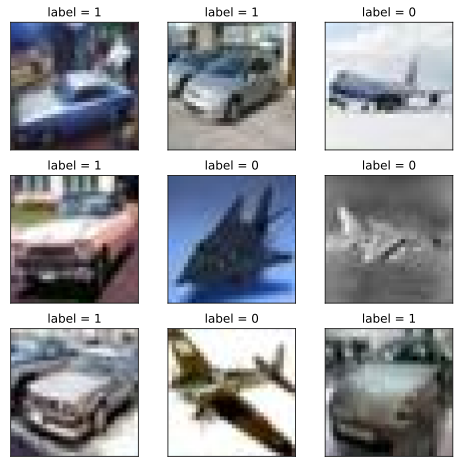

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [25]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


#### 定义模型


使用Keras接口有以下3种方式构建模型：

- 使用Sequential按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承Model基类构建自定义模型

此处选择使用函数式API构建模型

In [26]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

#### 训练模型

训练模型通常有3种方法：

- 内置fit方法
- 内置train_on_batch方法
- 自定义训练循环

此处我们选择最常用也最简单的内置fit方法。

In [27]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 1s 10ms/step - loss: 0.4260 - accuracy: 0.7996 - val_loss: 0.3154 - val_accuracy: 0.8665
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 0.3081 - accuracy: 0.8680 - val_loss: 0.2635 - val_accuracy: 0.8925
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.2579 - accuracy: 0.8948 - val_loss: 0.2201 - val_accuracy: 0.9115
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 0.2193 - accuracy: 0.9123 - val_loss: 0.2183 - val_accuracy: 0.9080
Epoch 5/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1882 - accuracy: 0.9252 - val_loss: 0.1851 - val_accuracy: 0.9310
Epoch 6/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1693 - accuracy: 0.9363 - val_loss: 0.1714 - val_accuracy: 0.9310
Epoch 7/10
100/100 [==============================] - 1s 9ms/step - loss: 0.1466 - accuracy: 0.9429 - val_loss: 0.1642 - val_accuracy: 0.9340
Epoch

#### 评估模型

In [30]:
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir ./data/keras_model (started 0:02:06 ago; pid 519)


In [32]:
#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")

Reusing TensorBoard on port 6006 (pid 519), started 0:02:16 ago. (Use '!kill 519' to kill it.)

In [29]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.425995,0.7996,0.315434,0.8665
2,0.308104,0.8680,0.263531,0.8925
3,0.257905,0.8948,0.220063,0.9115
4,0.219301,0.9123,0.218294,0.9080
5,0.188247,0.9252,0.185080,0.9310
6,0.169347,0.9363,0.171415,0.9310
7,0.146625,0.9429,0.164185,0.9340
8,0.138303,0.9470,0.173404,0.9320
9,0.118692,0.9543,0.169861,0.9320


In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

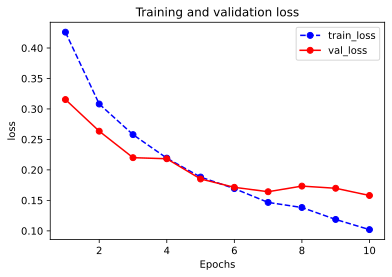

In [34]:
plot_metric(history,"loss")

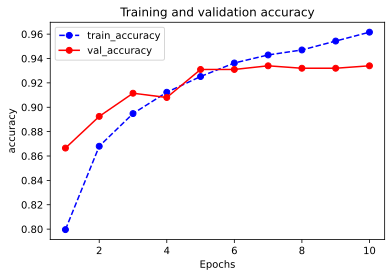

In [35]:
plot_metric(history,"accuracy")

In [36]:
# 可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 5ms/step - loss: 0.1580 - accuracy: 0.9340
0.1579943150281906 0.9340000152587891


#### 使用模型

- 可以使用model.predict(ds_test)进行预测。
- 可以使用model.predict_on_batch(x_test)对一个批量进行预测。

In [37]:
model.predict(ds_test)

array([[6.4856857e-01],
       [9.9932003e-01],
       [2.0017686e-05],
       ...,
       [9.9337631e-01],
       [3.8327898e-03],
       [4.2514532e-04]], dtype=float32)

In [38]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[8.8849956e-01]
 [5.9769617e-04]
 [9.7809315e-01]
 [9.9903524e-01]
 [9.1890675e-01]
 [1.0246566e-02]
 [3.8106637e-03]
 [8.3489519e-01]
 [4.3317820e-03]
 [9.9998546e-01]
 [2.1413717e-02]
 [2.5603941e-04]
 [1.8045523e-04]
 [9.9734712e-01]
 [2.3647046e-01]
 [8.7527412e-01]
 [6.2612216e-03]
 [1.6598338e-01]
 [5.2631170e-01]
 [9.9995863e-01]]


#### 保存模型

推荐使用TensorFlow原生方式保存模型。

In [40]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [41]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.
20/20 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9340


[0.15799430012702942, 0.9340000152587891]

### 文本数据建模流程

#### 准备数据

imdb数据集的目标是**根据电影评论的文本内容预测评论的情感标签**。训练集有20000条电影评论文本，测试集有5000条电影评论文本，其中正面评论和负面评论都各占一半。文本数据预处理较为繁琐，包括中文切词（本示例不涉及），构建词典，编码转换，序列填充，构建数据管道等等。

在tensorflow中完成文本数据预处理的常用方案有两种：

- 第一种是利用 `tf.keras.preprocessing` 中的Tokenizer词典构建工具和 `tf.keras.utils.Sequence` 构建文本数据生成器管道，这种方法较为复杂，其使用范例可以参考[以下文章](https://zhuanlan.zhihu.com/p/67697840)
- 第二种是使用 `tf.data.Dataset` 搭配 `.keras.layers.experimental.preprocessing.TextVectorization`预处理层，这种方法为TensorFlow原生方式，相对也更加简单一些。

我们此处介绍第二种方法。

![](./data/电影评论.jpg)

In [42]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers,preprocessing,optimizers,losses,metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re,string

train_data_path = "./data/imdb/train.csv"
test_data_path =  "./data/imdb/test.csv"

MAX_WORDS = 10000  # 仅考虑最高频的10000个词
MAX_LEN = 200  # 每个样本保留200个词的长度
BATCH_SIZE = 20 


# 构建管道
def split_line(line):
    arr = tf.strings.split(line,"\t")
    label = tf.expand_dims(tf.cast(tf.strings.to_number(arr[0]),tf.int32),axis = 0)
    text = tf.expand_dims(arr[1],axis = 0)
    return (text,label)

ds_train_raw =  tf.data.TextLineDataset(filenames = [train_data_path]) \
   .map(split_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test_raw = tf.data.TextLineDataset(filenames = [test_data_path]) \
   .map(split_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)


# 构建词典
def clean_text(text):
    lowercase = tf.strings.lower(text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    cleaned_punctuation = tf.strings.regex_replace(stripped_html,
         '[%s]' % re.escape(string.punctuation),'')
    return cleaned_punctuation

vectorize_layer = TextVectorization(
    standardize=clean_text,
    split = 'whitespace',
    max_tokens=MAX_WORDS-1, #有一个留给占位符
    output_mode='int',
    output_sequence_length=MAX_LEN)

ds_text = ds_train_raw.map(lambda text,label: text)
vectorize_layer.adapt(ds_text)
print(vectorize_layer.get_vocabulary()[0:100])


# 单词编码
ds_train = ds_train_raw.map(lambda text,label:(vectorize_layer(text),label)) \
    .prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test_raw.map(lambda text,label:(vectorize_layer(text),label)) \
    .prefetch(tf.data.experimental.AUTOTUNE)

[b'the', b'and', b'a', b'of', b'to', b'is', b'in', b'it', b'i', b'this', b'that', b'was', b'as', b'for', b'with', b'movie', b'but', b'film', b'on', b'not', b'you', b'his', b'are', b'have', b'be', b'he', b'one', b'its', b'at', b'all', b'by', b'an', b'they', b'from', b'who', b'so', b'like', b'her', b'just', b'or', b'about', b'has', b'if', b'out', b'some', b'there', b'what', b'good', b'more', b'when', b'very', b'she', b'even', b'my', b'no', b'would', b'up', b'time', b'only', b'which', b'story', b'really', b'their', b'were', b'had', b'see', b'can', b'me', b'than', b'we', b'much', b'well', b'get', b'been', b'will', b'into', b'people', b'also', b'other', b'do', b'bad', b'because', b'great', b'first', b'how', b'him', b'most', b'dont', b'made', b'then', b'them', b'films', b'movies', b'way', b'make', b'could', b'too', b'any', b'after', b'characters']


#### 定义模型

使用Keras接口有以下3种方式构建模型：

- 使用Sequential按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承Model基类构建自定义模型

此处选择使用继承Model基类构建自定义模型。

In [43]:
# 演示自定义模型范例，实际上应该优先使用Sequential或者函数式API
tf.keras.backend.clear_session()

class CnnModel(models.Model):
    def __init__(self):
        super(CnnModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN)
        self.conv_1 = layers.Conv1D(16, kernel_size= 5,name = "conv_1",activation = "relu")
        self.pool_1 = layers.MaxPool1D(name = "pool_1")
        self.conv_2 = layers.Conv1D(128, kernel_size=2,name = "conv_2",activation = "relu")
        self.pool_2 = layers.MaxPool1D(name = "pool_2")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(CnnModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return(x)
    
    # 用于显示Output Shape
    def summary(self):
        x_input = layers.Input(shape = MAX_LEN)
        output = self.call(x_input)
        model = tf.keras.Model(inputs = x_input,outputs = output)
        model.summary()
    
model = CnnModel()
model.build(input_shape =(None,MAX_LEN))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv_1 (Conv1D)              (None, 196, 16)           576       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 98, 16)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 97, 128)           4224      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 48, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0     

In [44]:
# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)
    
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

In [45]:
optimizer = optimizers.Nadam()
loss_func = losses.BinaryCrossentropy()

train_loss = metrics.Mean(name='train_loss')
train_metric = metrics.BinaryAccuracy(name='train_accuracy')

valid_loss = metrics.Mean(name='valid_loss')
valid_metric = metrics.BinaryAccuracy(name='valid_accuracy')


@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features,training = True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)
    

@tf.function
def valid_step(model, features, labels):
    predictions = model(features,training = False)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)


def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)
        
        #此处logs模板需要根据metric具体情况修改
        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}' 
        
        if epoch%1==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
            tf.print("")
        
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,ds_train,ds_test,epochs = 6)

================================================================================17:17:07
Epoch=1,Loss:0.49603,Accuracy:0.7161,Valid Loss:0.389060557,Valid Accuracy:0.8362

================================================================================17:17:11
Epoch=2,Loss:0.264220834,Accuracy:0.8933,Valid Loss:0.33611989,Valid Accuracy:0.8652

================================================================================17:17:16
Epoch=3,Loss:0.19330591,Accuracy:0.9275,Valid Loss:0.375903875,Valid Accuracy:0.8564

================================================================================17:17:20
Epoch=4,Loss:0.137741789,Accuracy:0.9502,Valid Loss:0.426500291,Valid Accuracy:0.8614

================================================================================17:17:25
Epoch=5,Loss:0.0952602178,Accuracy:0.96685,Valid Loss:0.518530488,Valid Accuracy:0.859

================================================================================17:17:29
Epoch=6,Loss:0.0558619201,Accuracy:0

#### 评估模型

通过自定义训练循环训练的模型没有经过编译，无法直接使用model.evaluate(ds_valid)方法

In [46]:
def evaluate_model(model,ds_valid):
    for features, labels in ds_valid:
         valid_step(model,features,labels)
    logs = 'Valid Loss:{},Valid Accuracy:{}' 
    tf.print(tf.strings.format(logs,(valid_loss.result(),valid_metric.result())))
    
    valid_loss.reset_states()
    train_metric.reset_states()
    valid_metric.reset_states()

    
evaluate_model(model,ds_test)

Valid Loss:0.669405282,Valid Accuracy:0.8532


#### 使用模型

可以使用以下方法:

- model.predict(ds_test)
- model(x_test)
- model.call(x_test)
- model.predict_on_batch(x_test)

推荐优先使用 `model.predict(ds_test)` 方法，既可以对Dataset，也可以对Tensor使用。

In [47]:
model.predict(ds_test)

array([[0.29460868],
       [0.99983704],
       [0.9996263 ],
       ...,
       [0.9005735 ],
       [0.24551833],
       [1.        ]], dtype=float32)

In [48]:
for x_test,_ in ds_test.take(1):
    print(model(x_test))
    #以下方法等价：
    #print(model.call(x_test))
    #print(model.predict_on_batch(x_test))

tf.Tensor(
[[2.9460868e-01]
 [9.9983704e-01]
 [9.9962628e-01]
 [6.8616668e-05]
 [6.0643303e-01]
 [2.3261497e-05]
 [6.7484507e-06]
 [1.0486152e-05]
 [9.9922490e-01]
 [5.8083957e-01]
 [9.9923825e-01]
 [8.1611812e-01]
 [1.1061561e-04]
 [9.0096968e-01]
 [1.7158875e-07]
 [4.2858899e-02]
 [1.0780863e-04]
 [6.3591853e-02]
 [9.4684023e-05]
 [9.5670867e-01]], shape=(20, 1), dtype=float32)


#### 保存模型

推荐使用TensorFlow原生方式保存模型。

In [49]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.predict(ds_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


array([[0.29460868],
       [0.99983704],
       [0.9996263 ],
       ...,
       [0.9005735 ],
       [0.24551833],
       [1.        ]], dtype=float32)

### 时间序列数据建模流程

本小节将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

#### 准备数据

本文的数据集取自tushare，数据集在本项目的 data 目录下。

![](./data/1-4-新增人数.png)



(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

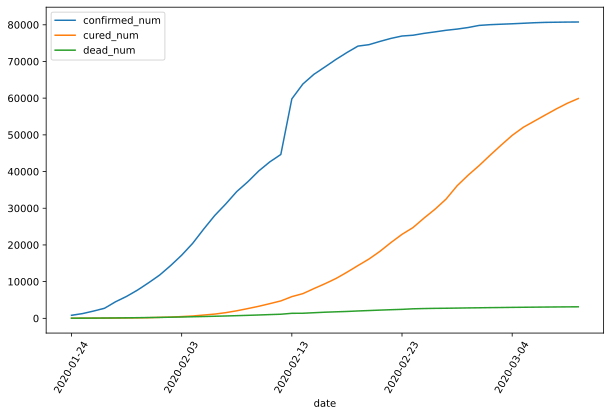

In [50]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

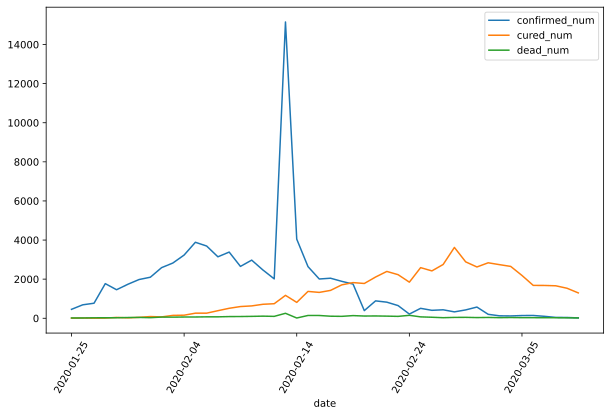

In [51]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [52]:
# 用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

# 数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

#### 定义模型

使用Keras接口有以下3种方式构建模型：

- 使用Sequential按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承Model基类构建自定义模型

此处选择使用函数式API构建任意结构模型。

In [53]:
# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [54]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
# x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

#### 训练模型

训练模型通常有3种方法：

- 内置fit方法
- 内置train_on_batch方法
- 自定义训练循环

此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [56]:
# 自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [57]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 0s 19ms/step - loss: 3.4135 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 3.0553 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 10ms/step - loss: 2.7220 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 10ms/step - loss: 2.3993 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 11ms/step - loss: 2.0693 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 10ms/step - loss: 1.7252 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 1.3741 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 1.0342 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7340 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 10ms/step - loss: 0.5099 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 10ms/step - loss: 0.3983 

Epoch 175/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4464 - lr: 0.0050
Epoch 176/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4464 - lr: 0.0050
Epoch 177/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4464 - lr: 0.0050
Epoch 178/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4464 - lr: 0.0050
Epoch 179/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4464 - lr: 0.0050
Epoch 180/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4464 - lr: 0.0050
Epoch 181/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4464 - lr: 0.0050
Epoch 182/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4464 - lr: 0.0050
Epoch 183/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4464 - lr: 0.0050
Epoch 184/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4464 - lr: 0.0050
Epoch 185/500
1/1 [==============================] - 0s 10ms/st

#### 评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

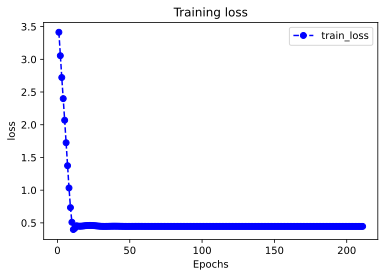

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()
plot_metric(history,"loss")

#### 使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [60]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [63]:
# 预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)


In [64]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
50,0.0,1237.0,0.0
51,0.0,1226.0,0.0
52,0.0,1215.0,0.0
53,0.0,1204.0,0.0
54,0.0,1193.0,0.0


In [65]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num


In [66]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
46,9.0,1285.0,0.0
47,4.0,1273.0,0.0
48,2.0,1261.0,0.0
49,1.0,1249.0,0.0
50,0.0,1237.0,0.0


In [68]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


In [69]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1095.3774  ,   87.81646 ,    0.      ],
       [1351.0872  ,   68.85609 ,    0.      ],
       [1474.2454  ,  146.6934  ,    0.      ],
       [1687.163   ,  156.67255 ,    0.      ],
       [2027.9354  ,  259.45773 ,    0.      ],
       [1927.739   ,  260.45563 ,    0.      ],
       [1640.1959  ,  386.19284 ,    0.      ],
       [1766.4852  ,  508.9363  ,    0.      ],
       [1383.9642  ,  597.7507  ,    0.      ],
       [1551.4802  ,  630.6818  ,    0.      ],
       [1287.4207  ,  713.5087  ,    0.      ],
       [1051.5414  ,  742.44824 ,    0.      ],
       [7906.6523  , 1168.5576  ,    0.      ],
       [2111.9543  ,  810.3064  ,    0.      ],
       [1378.2238  , 1370.1364  ,    0.      ],
       [1047.8884  , 1320.2406  ,    0.      ],
       [1068.7627  , 1422.028   ,    0.      ],
       [ 985.2656  , 1704.4376  ,    0.      ],
       [ 912.72754 , 1820.1957  ,    0.      ],
       [ 204.21422 , 1775.998   ,    0.      ],
       [ 464.58737 , 2104.3105  ,    0. 